In [ ]:
#!pip install qlearnkit['pennylane']
#!pip install --upgrade scipy pennylane
#!pip install pennylane
#!pip install --upgrade numpy pennylane
#!pip install pennylane-lightning
#!pip install --upgrade torch



In [ ]:
import torch
import torch.nn as nn
import pennylane as qml
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class QLSTM(nn.Module):

    def custom_encoding(self, inputs, wires):
        # Apply Hadamard to each qubit to create an unbiased initial state
        for wire in range(self.n_qubits):
            qml.Hadamard(wires=wire)

        qml.templates.AngleEmbedding(torch.arctan(inputs), rotation='Y', wires=wires)
        qml.templates.AngleEmbedding(torch.arctan(inputs ** 2), rotation='Z', wires=wires)

    def custom_entangler_layer(self, weights, wires):
        for l in range(self.n_qlayers):  # Repeat the sequence twice
            # Apply CNOTs for the specified entanglement structure
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 2])
            qml.CNOT(wires=[2, 3])
            qml.CNOT(wires=[3, 0])
            qml.CNOT(wires=[0, 2])
            qml.CNOT(wires=[1, 3])
            qml.CNOT(wires=[2, 0])
            qml.CNOT(wires=[3, 1])

            # Apply general rotation for each qubit
            for i, wire in enumerate(wires):
                qml.Rot(*weights[l, i, :], wires=wire)

    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=4,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        self.wires_forget = list(range(self.n_qubits))
        self.wires_input = list(range(self.n_qubits))
        self.wires_update = list(range(self.n_qubits))
        self.wires_output = list(range(self.n_qubits))
        self.wires_hidden = list(range(self.n_qubits))
        self.wires_output_pre = list(range(self.n_qubits))

        self.dev_forget = qml.device('default.qubit', wires=self.wires_forget)
        self.dev_input = qml.device('default.qubit', wires=self.wires_input)
        self.dev_update = qml.device('default.qubit', wires=self.wires_update)
        self.dev_output = qml.device('default.qubit', wires=self.wires_output)
        self.dev_hidden = qml.device('default.qubit', wires=self.wires_hidden)
        self.dev_output_pre = qml.device('default.qubit', wires=self.wires_output_pre)

        def _circuit_forget(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_forget)
            self.custom_entangler_layer(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_input)
            self.custom_entangler_layer(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_update)
            self.custom_entangler_layer(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_output)
            self.custom_entangler_layer(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        def _circuit_hidden(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_hidden)
            self.custom_entangler_layer(weights, wires=self.wires_hidden)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_hidden]
        self.qlayer_hidden = qml.QNode(_circuit_hidden, self.dev_hidden, interface="torch")

        def _circuit_output_pre(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_output_pre)
            self.custom_entangler_layer(weights, wires=self.wires_output_pre)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output_pre]
        self.qlayer_output_pre = qml.QNode(_circuit_output_pre, self.dev_output_pre, interface="torch")

        weight_shapes = {"weights": (self.n_qlayers, self.n_qubits, 3)}
        print(f"weight_shapes = (n_qlayers, n_qubits, 3) = ({n_qlayers}, {n_qubits}, 3)")

        self.clayer_in = torch.nn.Linear(self.hidden_size + self.n_inputs, self.n_qubits)
        print("Initialized clayer_in weight shape:", self.clayer_in.weight.shape)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes),
            'hidden': qml.qnn.TorchLayer(self.qlayer_hidden, weight_shapes),
            'output_pre': qml.qnn.TorchLayer(self.qlayer_output_pre, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        self.swish = Swish()  # the Swish activation function here

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> Swish
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)
            v_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](v_t)))
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](v_t)))
            g_t = self.swish(self.clayer_out(self.VQC['update'](v_t)))  #  Swish here
            c_t = (f_t * c_t) + (i_t * g_t)

            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](v_t)))
            h_t = self.VQC['hidden'](o_t * self.swish(c_t))  #  Swish here
            y_tilde = self.VQC['output_pre'](o_t * self.swish(c_t))  #  Swish here
            y_t = self.clayer_out(y_tilde)

            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq, (h_t, c_t)

LSTM hidden layer size: 4
Number of qubits: 0
Training epochs: 100
Learning rate: 0.01
RMSprop alpha: 0.99
RMSprop eps: 1e-08
Sample size: 250
Sequence length: 4
Input size: 1
Tagger will use Classical LSTM
Epoch 1, Train Loss: 0.9323, Test Loss: 0.5668
Epoch 2, Train Loss: 0.8353, Test Loss: 0.5953
Epoch 3, Train Loss: 0.8041, Test Loss: 0.6060
Epoch 4, Train Loss: 0.7659, Test Loss: 0.5827
Epoch 5, Train Loss: 0.6798, Test Loss: 0.4922


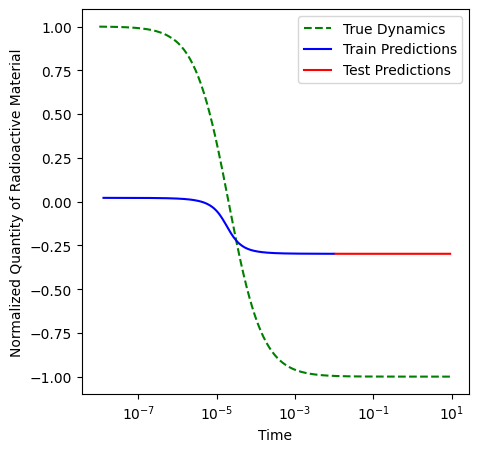

Epoch 6, Train Loss: 0.4972, Test Loss: 0.3375
Epoch 7, Train Loss: 0.2705, Test Loss: 0.2058
Epoch 8, Train Loss: 0.1285, Test Loss: 0.1233
Epoch 9, Train Loss: 0.0743, Test Loss: 0.0758
Epoch 10, Train Loss: 0.0554, Test Loss: 0.0491


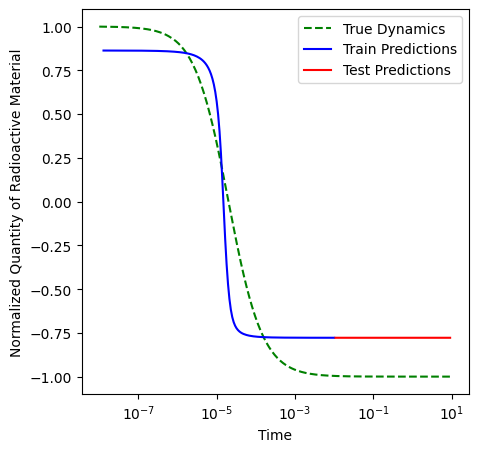

Epoch 11, Train Loss: 0.0462, Test Loss: 0.0333
Epoch 12, Train Loss: 0.0403, Test Loss: 0.0236
Epoch 13, Train Loss: 0.0352, Test Loss: 0.0173
Epoch 14, Train Loss: 0.0304, Test Loss: 0.0128
Epoch 15, Train Loss: 0.0260, Test Loss: 0.0093
Epoch 16, Train Loss: 0.0220, Test Loss: 0.0065
Epoch 17, Train Loss: 0.0184, Test Loss: 0.0043
Epoch 18, Train Loss: 0.0150, Test Loss: 0.0026
Epoch 19, Train Loss: 0.0117, Test Loss: 0.0015
Epoch 20, Train Loss: 0.0089, Test Loss: 0.0008
Epoch 21, Train Loss: 0.0064, Test Loss: 0.0004
Epoch 22, Train Loss: 0.0045, Test Loss: 0.0002
Epoch 23, Train Loss: 0.0030, Test Loss: 0.0001
Epoch 24, Train Loss: 0.0019, Test Loss: 0.0000
Epoch 25, Train Loss: 0.0013, Test Loss: 0.0000
Epoch 26, Train Loss: 0.0009, Test Loss: 0.0001
Epoch 27, Train Loss: 0.0009, Test Loss: 0.0002
Epoch 28, Train Loss: 0.0024, Test Loss: 0.0002
Epoch 29, Train Loss: 0.0070, Test Loss: 0.0002
Epoch 30, Train Loss: 0.0057, Test Loss: 0.0002


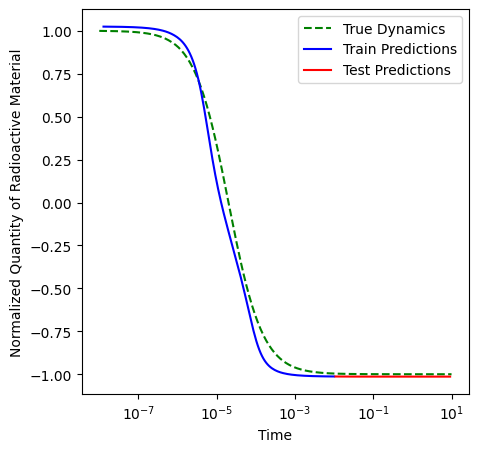

Epoch 31, Train Loss: 0.0152, Test Loss: 0.0048
Epoch 32, Train Loss: 0.0138, Test Loss: 0.0001
Epoch 33, Train Loss: 0.0068, Test Loss: 0.0004
Epoch 34, Train Loss: 0.0093, Test Loss: 0.0006
Epoch 35, Train Loss: 0.0026, Test Loss: 0.0005
Epoch 36, Train Loss: 0.0020, Test Loss: 0.0004
Epoch 37, Train Loss: 0.0012, Test Loss: 0.0003
Epoch 38, Train Loss: 0.0015, Test Loss: 0.0003
Epoch 39, Train Loss: 0.0010, Test Loss: 0.0002
Epoch 40, Train Loss: 0.0009, Test Loss: 0.0002
Epoch 41, Train Loss: 0.0008, Test Loss: 0.0002
Epoch 42, Train Loss: 0.0009, Test Loss: 0.0002
Epoch 43, Train Loss: 0.0008, Test Loss: 0.0001
Epoch 44, Train Loss: 0.0007, Test Loss: 0.0001
Epoch 45, Train Loss: 0.0006, Test Loss: 0.0002
Epoch 46, Train Loss: 0.0008, Test Loss: 0.0001
Epoch 47, Train Loss: 0.0007, Test Loss: 0.0000
Epoch 48, Train Loss: 0.0008, Test Loss: 0.0000
Epoch 49, Train Loss: 0.0007, Test Loss: 0.0002
Epoch 50, Train Loss: 0.0018, Test Loss: 0.0001


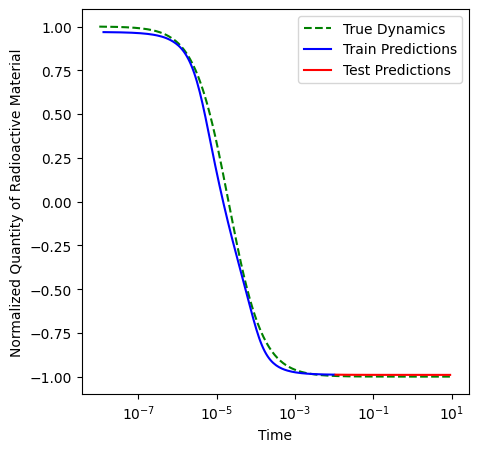

Epoch 51, Train Loss: 0.0014, Test Loss: 0.0002
Epoch 52, Train Loss: 0.0038, Test Loss: 0.0005
Epoch 53, Train Loss: 0.0025, Test Loss: 0.0004
Epoch 54, Train Loss: 0.0155, Test Loss: 0.0002
Epoch 55, Train Loss: 0.0072, Test Loss: 0.0010
Epoch 56, Train Loss: 0.0112, Test Loss: 0.0015
Epoch 57, Train Loss: 0.0032, Test Loss: 0.0002
Epoch 58, Train Loss: 0.0057, Test Loss: 0.0002
Epoch 59, Train Loss: 0.0019, Test Loss: 0.0000
Epoch 60, Train Loss: 0.0021, Test Loss: 0.0000
Epoch 61, Train Loss: 0.0009, Test Loss: 0.0002
Epoch 62, Train Loss: 0.0014, Test Loss: 0.0001
Epoch 63, Train Loss: 0.0009, Test Loss: 0.0000
Epoch 64, Train Loss: 0.0009, Test Loss: 0.0000
Epoch 65, Train Loss: 0.0007, Test Loss: 0.0002
Epoch 66, Train Loss: 0.0008, Test Loss: 0.0000
Epoch 67, Train Loss: 0.0009, Test Loss: 0.0002
Epoch 68, Train Loss: 0.0008, Test Loss: 0.0000
Epoch 69, Train Loss: 0.0012, Test Loss: 0.0003
Epoch 70, Train Loss: 0.0010, Test Loss: 0.0000
Epoch 71, Train Loss: 0.0022, Test Loss:

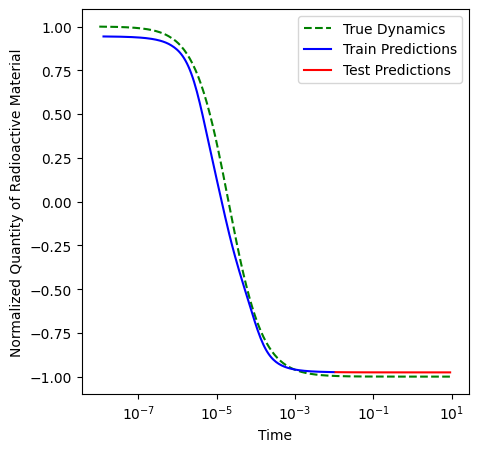

Train MAE: 25.7313, Train RMSE: 33.8402
Test MAE: 11.95525646, Test RMSE: 11.95768452


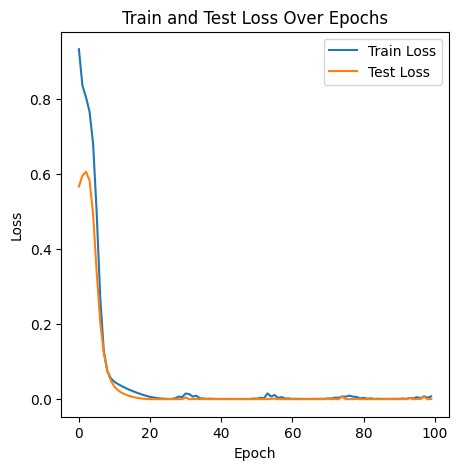

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the LSTM model
class LSTMTagger(nn.Module):
    def __init__(self, input_size, hidden_dim, sequence_length, n_qubits=0, output_size=1, num_layers=2, backend='default.qubit'):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        if n_qubits > 0:
            print(f"Tagger will use Quantum LSTM running on backend {backend}")
            self.lstm = QLSTM(input_size, hidden_dim, n_qubits=n_qubits)
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_timestep_output = lstm_out[:, -1, :]
        fc_out = self.fc(last_timestep_output)
        return fc_out

batch_size = 64
# Hyperparameters and configurations
class Args:
    hidden_dim = 4
    n_qubits = 0
    n_epochs = 100
    backend = 'default.qubit'
    learning_rate = 0.01
    sequence_length = 4
    sample_size = 250
    alpha = 0.99
    eps = 1e-8
    input_size = 1

args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"LSTM hidden layer size: {args.hidden_dim}")
print(f"Number of qubits: {args.n_qubits}")
print(f"Training epochs: {args.n_epochs}")
print(f"Learning rate: {args.learning_rate}")
print(f"RMSprop alpha: {args.alpha}")
print(f"RMSprop eps: {args.eps}")
print(f"Sample size: {args.sample_size}")
print(f"Sequence length: {args.sequence_length}")
print(f"Input size: {args.input_size}")

# Constants for the radioactive decay with chain reactions
lambda1 = 0.1  # primary decay constant
lambda2 = 50.0  # chain reaction decay constant
N0 = 1000.0  # initial quantity of radioactive material

# Differential equation for radioactive decay with chain reactions
def radioactive_decay(t, N):
    return -lambda1 * N - lambda2 * N**2

# Time span and time steps for the simulation using logarithmic spacing
t_span = (1e-8, 1e1)
t_eval = np.logspace(-8, 1, args.sample_size)

# Solve the differential equation using an appropriate solver for stiff ODEs
solution = solve_ivp(radioactive_decay, t_span, [N0], t_eval=t_eval, method='LSODA')

# Extract the results
time_points = solution.t
quantities = solution.y[0]

# Normalize the data
N_min, N_max = np.min(quantities), np.max(quantities)
N_normalized = 2 * (quantities - N_min) / (N_max - N_min) - 1

# Reshape the data for LSTM input
num_samples = len(t_eval) - args.sequence_length + 1
input_size = 1

# Initialize data array
data = np.zeros((num_samples, args.sequence_length, input_size))

# Populate the data array with sequences of radioactive material quantities
for i in range(num_samples):
    data[i, :, 0] = N_normalized[i:i + args.sequence_length]

# Convert to a PyTorch tensor
data = torch.tensor(data, dtype=torch.float32)
input_sequences = data[:-1]
labels = data[1:, -1, 0].unsqueeze(-1)
dataset = TensorDataset(input_sequences, labels)

# Split the data into training and testing sets
train_size = int(0.67 * len(dataset))
test_size = len(dataset) - train_size

# Create subsets to maintain order
train_dataset = Subset(dataset, list(range(train_size)))
test_dataset = Subset(dataset, list(range(train_size, len(dataset))))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = LSTMTagger(input_size=args.input_size, hidden_dim=args.hidden_dim,
                   sequence_length=args.sequence_length, n_qubits=args.n_qubits,
                   output_size=1, backend=args.backend).float().to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=args.learning_rate, alpha=args.alpha, eps=args.eps)

# Training loop
train_losses = []
test_losses = []

for epoch in range(1, args.n_epochs + 1):
    model.train()
    epoch_train_losses = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)

    # Evaluation on test data using test_loader
    model.eval()
    epoch_test_losses = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            epoch_test_losses.append(loss.item())

    avg_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    if epoch in [5, 10, 30, 50, 100]:
        model.eval()
        with torch.no_grad():
            train_preds = [model(batch[0].to(device)) for batch in train_loader]
            test_preds = [model(batch[0].to(device)) for batch in test_loader]

        train_preds = torch.cat(train_preds, dim=0)
        test_preds = torch.cat(test_preds, dim=0)

        x_original = solution.t

        fig, ax = plt.subplots(figsize=(5, 5))

        # Plot true dynamics
        ax.plot(x_original, N_normalized, 'g--', label='True Dynamics')

        # Calculate the correct starting index for predictions
        start_index = args.sequence_length - 1
        end_index = start_index + len(train_preds)

        # Plot training predictions
        ax.plot(x_original[start_index:end_index], train_preds.cpu().numpy(), 'b', label='Train Predictions')

        # Calculate the correct indices for test predictions
        start_index = end_index
        end_index = start_index + len(test_preds)

        # Plot testing predictions
        ax.plot(x_original[start_index:end_index], test_preds.cpu().numpy(), 'r', label='Test Predictions')

        ax.set_ylabel('Normalized Quantity of Radioactive Material')
        ax.set_xlabel('Time')
        ax.set_xscale('log')
        ax.legend()


        plt.show()

# Function to denormalize data
def denormalize(norm_data, original_min, original_max):
    return norm_data * (original_max - original_min) / 2 + (original_max + original_min) / 2

# Function to calculate metrics
def calculate_metrics(true_labels_np, predictions_np):
    mae = mean_absolute_error(true_labels_np, predictions_np)
    rmse = np.sqrt(mean_squared_error(true_labels_np, predictions_np))
    return mae, rmse

# Final model evaluation
model.eval()
final_train_predictions = []
final_test_predictions = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        final_train_predictions.append(outputs)

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        final_test_predictions.append(outputs)

# Concatenate the list of tensors into a single tensor
final_train_predictions = torch.cat(final_train_predictions, dim=0)
final_test_predictions = torch.cat(final_test_predictions, dim=0)

# Concatenate all the labels from the DataLoader
train_labels = torch.cat([label for _, label in train_loader], dim=0)
test_labels = torch.cat([label for _, label in test_loader], dim=0)

# Move predictions and labels to CPU and convert to numpy arrays for metrics calculation
train_labels_np = train_labels.cpu().numpy()
test_labels_np = test_labels.cpu().numpy()
final_train_predictions_np = final_train_predictions.cpu().numpy()
final_test_predictions_np = final_test_predictions.cpu().numpy()

# Denormalize predictions and true labels
train_labels_denorm = denormalize(train_labels_np, N_min, N_max)
test_labels_denorm = denormalize(test_labels_np, N_min, N_max)
final_train_predictions_denorm = denormalize(final_train_predictions_np, N_min, N_max)
final_test_predictions_denorm = denormalize(final_test_predictions_np, N_min, N_max)

# Calculate MAE and RMSE for both train and test sets
train_mae, train_rmse = calculate_metrics(train_labels_denorm, final_train_predictions_denorm)
test_mae, test_rmse = calculate_metrics(test_labels_denorm, final_test_predictions_denorm)

# Output the metrics for denormalized predictions
print(f'Train MAE: {train_mae:.4f}, Train RMSE: {train_rmse:.4f}')
print(f'Test MAE: {test_mae:.8f}, Test RMSE: {test_rmse:.8f}')

# Plotting training and test losses over epochs
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
import numpy as np

# Given parameters
lambda1 = 0.1
lambda2 = 50.0
N_max = 1.0  # Assuming N_max is around 1.0 for simplicity

# Maximum eigenvalue (most negative value)
lambda_max = -lambda1 - 2 * lambda2 * N_max

# Minimum eigenvalue (least negative value, at N = 0)
lambda_min = -lambda1

# Stiffness ratio
stiffness_ratio = np.abs(lambda_max) / np.abs(lambda_min)

stiffness_ratio




1000.9999999999999